In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
#load main coronavirus data from DB

path = r'..\COVID-19\csse_covid_19_data\csse_covid_19_time_series'

Confirmed = pd.read_csv(path + "/time_series_covid19_confirmed_global.csv", index_col='Country/Region', header=0)
Deaths = pd.read_csv(path + "/time_series_covid19_deaths_global.csv", index_col='Country/Region', header=0)
Recovered = pd.read_csv(path + "/time_series_covid19_recovered_global.csv", index_col='Country/Region', header=0)

In [3]:
#load supplemental data

supp = r'./supplemental_data'

bloodtypes = pd.read_csv(supp + "/bloodtypes.csv", index_col='Country', header=0)
gdp = pd.read_csv(supp + "/gdp.csv", index_col='country', header=0)
healthcare_rank = pd.read_csv(supp + "/healthcare_rank.csv", index_col='area_name', header=0, encoding='latin-1')
smoking_rate = pd.read_csv(supp + "/smoking_rate.csv", index_col='name', header=0)

In [4]:
#classes
class Country:
    def __init__(self, n = ''):
        self.name = n
        self.population = gdp.loc[n]['pop'].sum()
        self.latitude = Confirmed.loc[n]['Long'].sum()
        self.longitude = Confirmed.loc[n]['Lat'].sum()
        self.confirmed = Confirmed.loc[n].drop(['Province/State', 'Lat', 'Long'], axis = 1).sum()
        self.confirmed.index = pd.to_datetime(self.confirmed.index)
        self.deaths = Deaths.loc[n].drop(['Province/State', 'Lat', 'Long'], axis = 1).sum()
        self.deaths.index = pd.to_datetime(self.deaths.index)
        self.recovered = Recovered.loc[n].drop(['Province/State', 'Lat', 'Long'], axis = 1).sum()
        self.recovered.index = pd.to_datetime(self.recovered.index)
        self.actual = self.confirmed - (self.deaths + self.recovered)
        self.actual.index = pd.to_datetime(self.actual.index)
        self.newCases = self.confirmed.copy()
        for i in range(1, len(self.newCases)):
            self.newCases[i] = self.newCases[i] - self.newCases[i-1]
        self.newCases.index = pd.to_datetime(self.newCases.index)
        
        self.healthcare_rank = healthcare_rank.loc[n]['score_2019'].sum()/100
        self.gdp_per_capita = gdp.loc[n]['gdpPerCapita'].sum()
        self.bloodtype_percentages = pd.to_numeric(bloodtypes.loc[n]['O+':'AB-'].str.strip('%'))/100
        self.smoking_rate = smoking_rate.loc[n]['totalSmokingRate']/100
        return
        
    name = ''
    population = 0              # in thousands
    latitude = ''               # in degrees
    longitude = ''              # in degrees
    confirmed = []
    deaths = []
    recovered = []
    actual = []
    newCases = []   
    healthcare_rank = 0         # normalized to range [0:1] (normally score from 0 to 100 where 100 is best)
    gdp_per_capita = 0          # in USD
    bloodtype_percentages = pd.Series([])  # in range [0:1] (percents)
    smoking_rate = 0            # in range [0:1] (percents)
    
    pass

class Logistic_curve:           # logistic function of confirmad cases
                                # works only for countries which have already overcome the disease
    def __init__(self, country = Country):
        self.y = np.asarray(country.confirmed.values)
        self.x = np.linspace(0, len(self.y), len(self.y))
        self.name = country.name
        #self.set_values()
        
    def sigmoid(self, x, L ,x0, k, b):
        y = L / (1 + np.exp(-k*(x-x0)))+b
        return (y)
    
    def set_values(self):       # find constants of logistic curve
        p0 = [max(self.y), np.median(self.x), 1, min(self.y)]
        popt, pcov = curve_fit(self.sigmoid, self.x, self.y, p0, method='dogbox')
        self.L = popt[0]
        self.x0 = popt[1]
        self.k = popt[2]
        self.b = popt[3]
        self.y_logistic_curve = self.sigmoid(self.x, *popt)
    
    name = ''
    L = ''                      # curve's maximum value
    x0 = ''                     # x-value of the sigmoid's midpoint (inflation point)
    k = ''                      # logistic growth rate of steepness of the curve
    b = ''                      # curve's minimum value
    x = []                      # days in numbers since 1/22
    y = []                      # confirmed cases since 1/22
    y_logistic_curve = []       # logistic curve's values
    
    pass


C:\Users\Szczena\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Max number of cases is: 82521


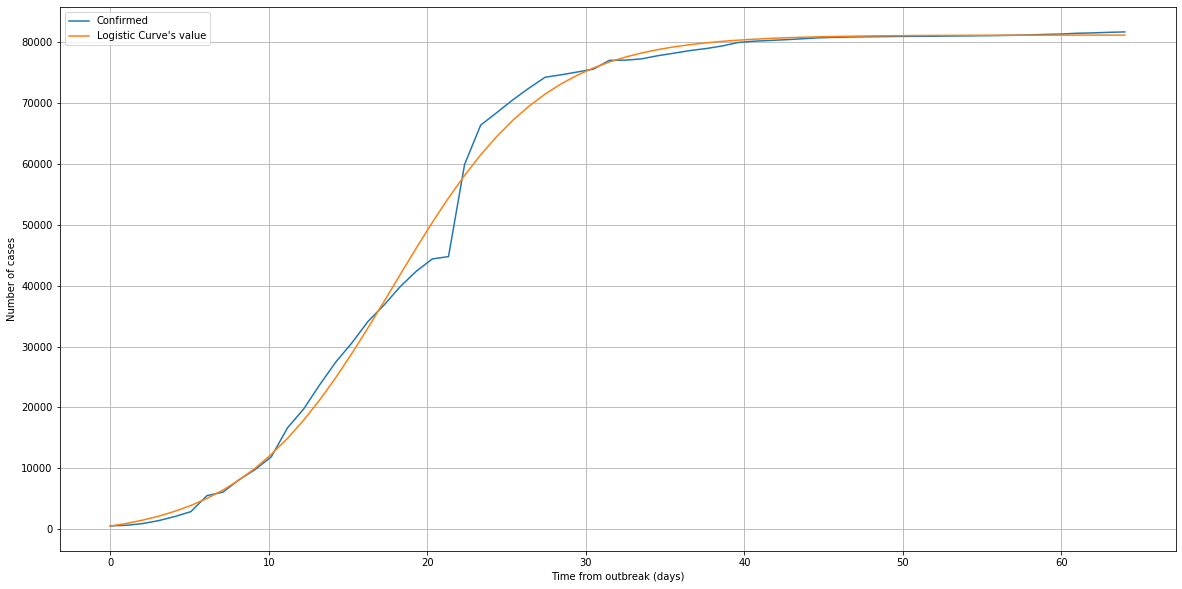

In [5]:
#analyzed country

analyzedCountry = Country('China')

a = Logistic_curve(analyzedCountry)
a.set_values()

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
#plt.style.use('ggplot')
plt.plot(a.x, a.y)
plt.plot(a.x, a.y_logistic_curve)
ax.set_xlabel('Time from outbreak (days)')
ax.set_ylabel('Number of cases', rotation=90)
plt.legend(['Confirmed','Logistic Curve\'s value'])
plt.grid()
print('Max number of cases is: '+str(int(a.L)))
plt.show()

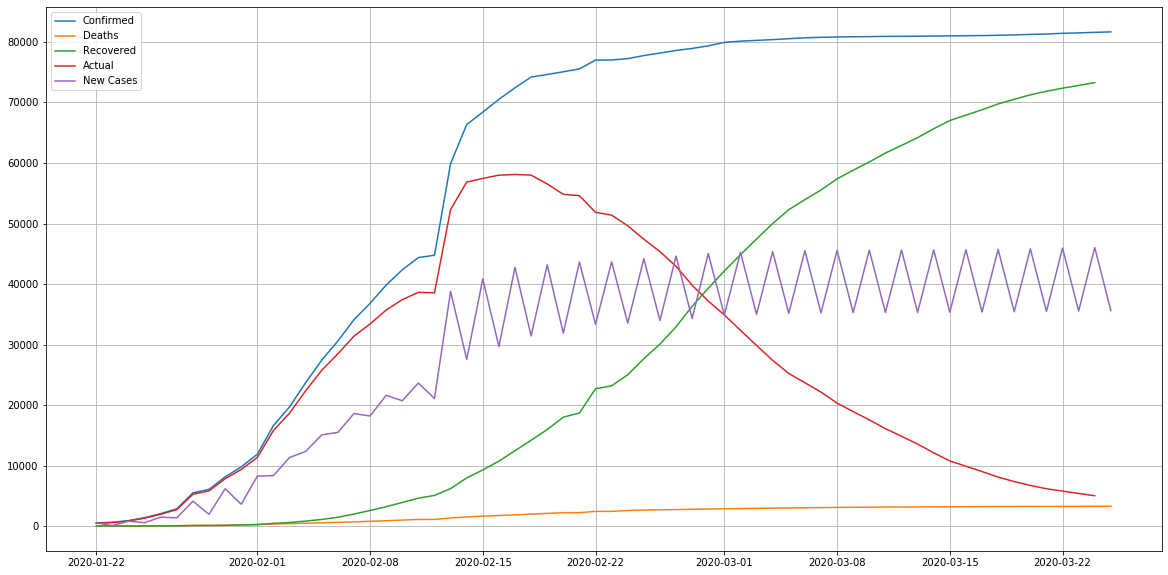

In [6]:
# Version 1
fig = plt.figure(figsize=(20, 10))

plt.plot(analyzedCountry.confirmed)
plt.plot(analyzedCountry.deaths)
plt.plot(analyzedCountry.recovered)
plt.plot(analyzedCountry.actual)
plt.plot(analyzedCountry.newCases)
plt.legend(['Confirmed', 'Deaths', 'Recovered', 'Actual', 'New Cases'])
plt.grid()
plt.show()

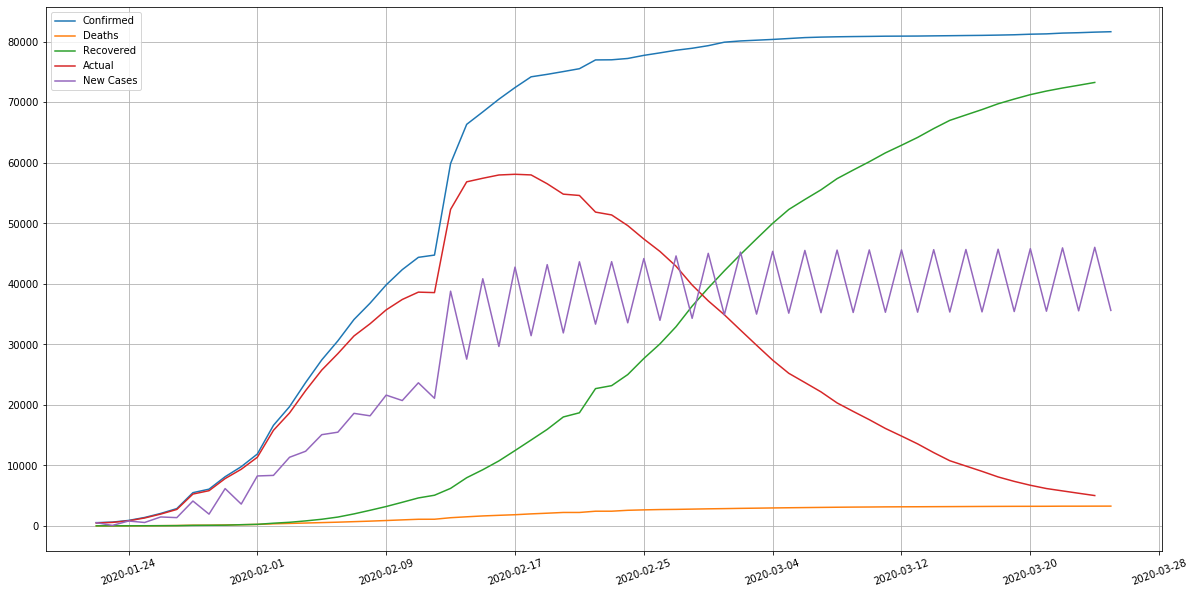

In [7]:
# Version 2
#display basic data for chosen country
degrees = 20
#fig, ax = plt.subplots(5,1)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
plots = [analyzedCountry.confirmed, analyzedCountry.deaths, analyzedCountry.recovered, analyzedCountry.actual, analyzedCountry.newCases]
titles = ['Confirmed', 'Deaths', 'Recovered', 'Actual', 'New Cases']
for i in range(5):
    ax.plot(plots[i])
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=degrees)
plt.legend(titles)
plt.grid()
plt.show()

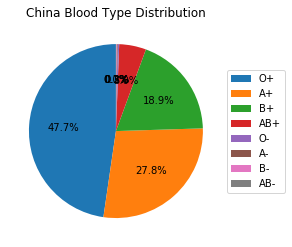

In [8]:
#bloodtype distribution

plt.title(analyzedCountry.name + " Blood Type Distribution")
plt.pie(analyzedCountry.bloodtype_percentages,  startangle=90, autopct='%1.1f%%')
plt.legend(analyzedCountry.bloodtype_percentages.index, loc='right',bbox_to_anchor=(1.3,0.5))
plt.show()

In [9]:
print(analyzedCountry.gdp_per_capita)

10746.7828


In [10]:
print(analyzedCountry.healthcare_rank)

0.809


In [11]:
print(analyzedCountry.smoking_rate)

0.247
